In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
fpath_gset = {\
'knowledge': '../../results/2021-07-01-high-conf-ADgenes/AD-genes-knowledge-extended',
'knowledge U TWAS2+': '../../results/2021-07-01-high-conf-ADgenes/AD-genes-knowledge-extended-TWAS2plus',
'agora2+': '../../resources/agora/AD-genes-agora-2plus-nominations',
'agora': '../../resources/agora/AD-genes-agora',
'DESudhir': '../../resources/CMap/sudhir-varma/up-down.genes-noNAs',
'DE APOE3-APOE3': '../../results/2021-11-28-ad-de-genes-apoe/ad-de-genes-apoe3-apoe3',
'DE APOE4-APOE4': '../../results/2021-11-28-ad-de-genes-apoe/ad-de-genes-apoe4-apoe4',
             }

In [3]:
describe_gset = {\
'knowledge': 'curated AD genes from the DISEASES database pulling from UniProtKB, AmyCo, GHR',
'knowledge U TWAS2+': 'AD genes in "knowledge" or supported by two or more TWAS',
'agora2+': 'AD genes supported by two or more studies in Agora https://agora.adknowledgeportal.org',
'agora': 'AD genes supported by any study in Agora https://agora.adknowledgeportal.org',
'DESudhir': 'AD vs control differentially expressed genes from Sudhir Varma',
'DE APOE3-APOE3': 'AD vs control differentially expressed genes given APOE3/APOE3 genotype from https://doi.org/10.1038/s43587-021-00122-7',
'DE APOE4-APOE4': 'AD vs control differentially expressed genes given APOE4/APOE4 genotype from https://doi.org/10.1038/s43587-021-00122-7',
             }

In [4]:
def read_gset(fpath):
    with open(fpath) as f:
        gset = set([s.strip() for s in f.readlines()])
    return(gset)

gset = {name: read_gset(fpath) for name, fpath in fpath_gset.items()}

In [5]:
def get_jaccard(gsetA, gsetB):
    jix = len(gsetA.intersection(gsetB)) / len(gsetA.union(gsetB))
    return(jix)

jaccard = pd.DataFrame([[get_jaccard(A, B) for B in gset.values()] for A in gset.values()], index=gset.keys(), columns=gset.keys())

In [6]:
fpath_prox = {\
'knowledge': 'AD-genes-knowledge-extended/AD-genes-knowledge-extended.csv',
'knowledge U TWAS2+': 'AD-genes-knowledge-extended-TWAS2plus/AD-genes-knowledge-extended-TWAS2plus.csv',
'agora2+': 'AD-genes-agora-2plus-nominations/AD-genes-agora-2plus-nominations.csv',
'agora': 'AD-genes-agora/AD-genes-agora.csv',
'DESudhir': 'up-down-sudhir/up-down-sudhir.csv',
'DE APOE3-APOE3': 'ad-de-genes-apoe3-apoe3/ad-de-genes-apoe3-apoe3.csv',
'DE APOE4-APOE4': 'ad-de-genes-apoe4-apoe4/ad-de-genes-apoe4-apoe4.csv',
             }

In [7]:
def read_prox(fpath):
    fpath = '../../results/proximity-runs/' + fpath
    df = pd.read_csv(fpath, index_col=0)
    df = df.sort_values('z').dropna(subset=['z'])
    df['rank'] = np.arange(len(df), dtype=np.int64) + 1
    return(df)

prox = {name: read_prox(fpath) for name, fpath in fpath_prox.items()}

## Pairwise similarity of drug prioritization under various AD gene sets
### Network proximity based Z score

['named-figure/prox-z-scatterplot_matrix.png',
 'named-figure/prox-z-scatterplot_matrix.pdf']

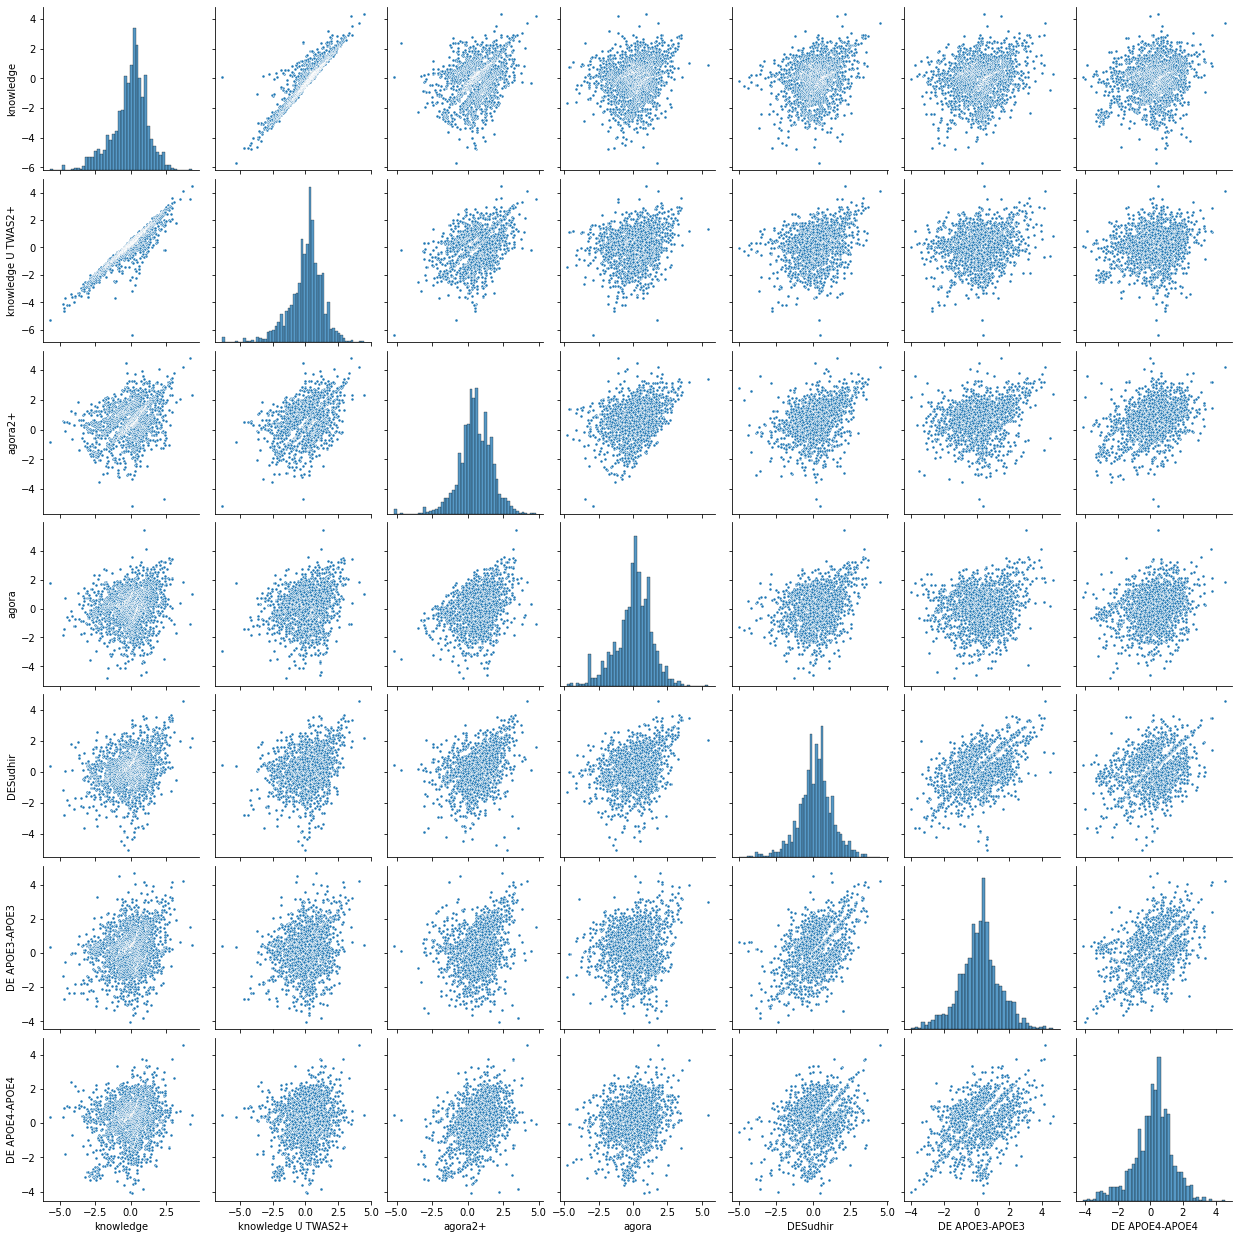

In [8]:
def scatterplot_matrix(col='z', prox=prox):
    df = pd.concat([df[col] for df in prox.values()], axis=1)
    df = df.set_axis(prox.keys(), axis=1)
    g = sns.pairplot(df, markers='.')
    return(g)

g = scatterplot_matrix('z')
attila_utils.savefig(g, 'prox-z-scatterplot_matrix')

Now the same information is summarized with Pearson's correlation coefficients

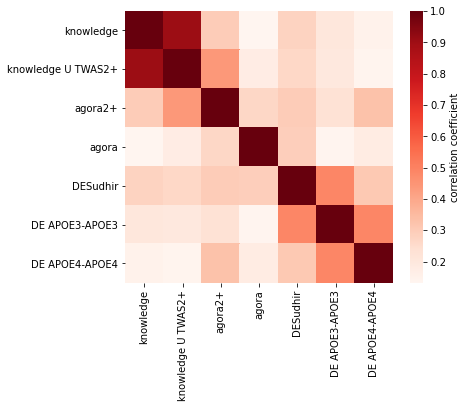

In [9]:
def correlation_heatmap(col='z', prox=prox):
    corr = pd.concat([df[col] for df in prox.values()], axis=1)
    corr = corr.set_axis(prox.keys(), axis=1)
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(corr.corr(), cmap='Reds', ax=ax)
    axi = fig.axes[1]
    axi.set_ylabel('correlation coefficient')
    return((fig, ax))

fig, ax = correlation_heatmap()

### Similarity of AD gene sets
The Jaccard index for pairs of AD gene sets shows a similar pattern suggesting that **similar input AD gene sets lead to similar drug score based on network proximity**.

Text(379.1700000000001, 0.5, 'Jaccard index')

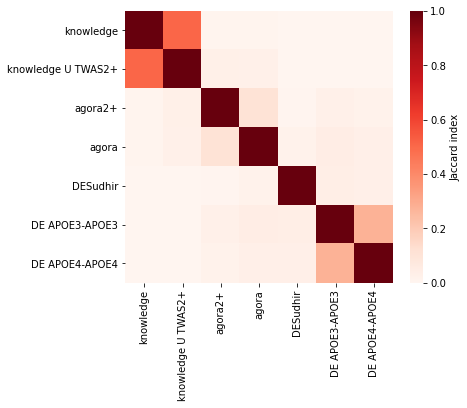

In [10]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(jaccard, cmap='Reds', ax=ax)
axi = fig.axes[1]
axi.set_ylabel('Jaccard index')

### Rank based similarity of drug prioritization

This plot shows qualitatively similar picture as its Z-score based equivalent.

['named-figure/prox-rank-scatterplot_matrix.png',
 'named-figure/prox-rank-scatterplot_matrix.pdf']

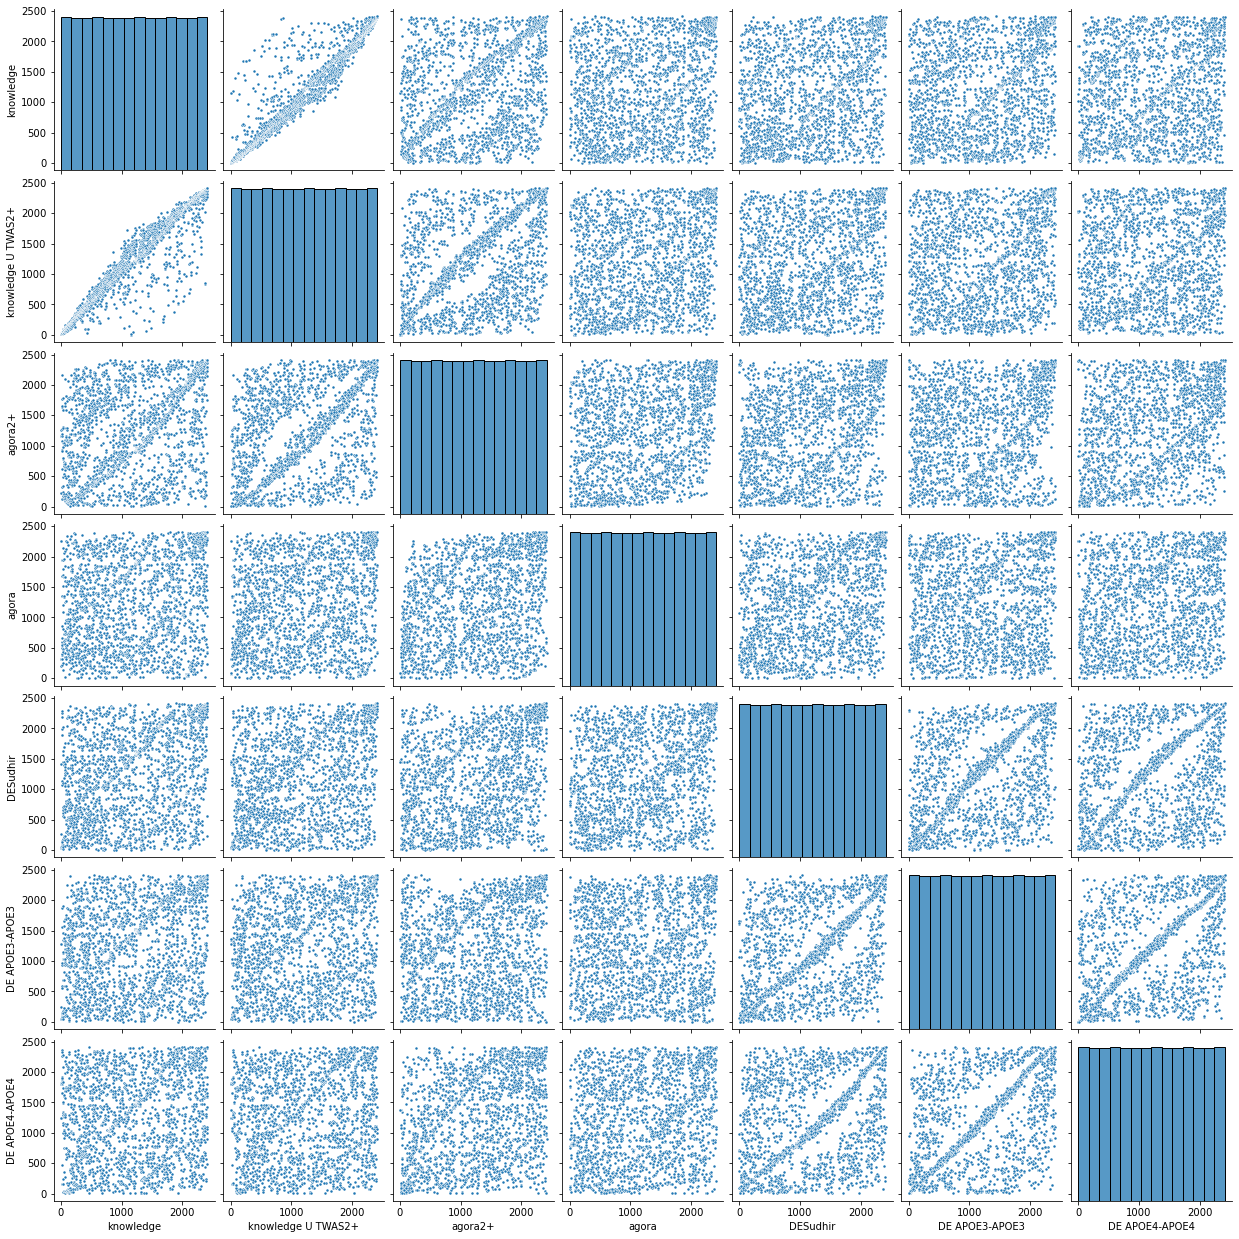

In [11]:
g = scatterplot_matrix('rank')
attila_utils.savefig(g, 'prox-rank-scatterplot_matrix')

In [12]:
def extract_scores(df, name=None):
    sel_cols = ['rank', 'z', 'p']
    df = df[sel_cols]
    df.columns = pd.MultiIndex.from_product([[name], sel_cols])
    return(df)

sel_cols = ['drug_name', 'max_phase', 'indication_class', 'uniprot_name', 'target_name']
info = prox['knowledge'][sel_cols]
info.columns = pd.MultiIndex.from_product([['drug information'], sel_cols])
merged_prox = pd.concat([info] + [extract_scores(df, name) for name, df in prox.items()], axis=1)

# write to an Excel document
fpath = '../../results/2021-12-02-proximity-various-ADgenesets/merged-proximity-chembl.xlsx'
with pd.ExcelWriter(fpath) as writer:
    # Manually remove blank row in Excel!  See issue:
    # https://stackoverflow.com/questions/52497554/blank-line-below-headers-created-when-using-multiindex-and-to-excel-
    merged_prox.to_excel(writer, 'drug rankings')
    pd.Series(describe_gset.values(), index=describe_gset.keys()).to_excel(writer, 'gene set description', header=False)
    for name, genes in gset.items():
        l = list(genes)
        l.sort()
        pd.Series(l).to_excel(writer, name, header=False, index=False)

In [13]:
%connect_info

{
  "shell_port": 59954,
  "iopub_port": 59955,
  "stdin_port": 59956,
  "control_port": 59958,
  "hb_port": 59957,
  "ip": "127.0.0.1",
  "key": "99257d1e-99c1fa1e2bb95c56e2a0a32a",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-1aa9ef35-6cd8-4d9c-bc25-898138aaa0e4.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
